In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Read the Data

In [2]:
data = pd.read_csv("train.csv" , parse_dates=['Tarih'] , index_col='Tarih')
# data.set_index('Tarih' , drop= True , inplace=True)
data.head()

,Dağıtılan Enerji (MWh)
Tarih,
2018-01-01 00:00:00,1593.944216
2018-01-01 01:00:00,1513.933887
2018-01-01 02:00:00,1402.612637
2018-01-01 03:00:00,1278.527266
2018-01-01 04:00:00,1220.697701


In [3]:
future_data = pd.read_csv("future.csv", parse_dates=['Tarih'] , index_col= 'Tarih').drop('Unnamed: 0' , axis = 1)
future_data.head()

,Dağıtılan Enerji (MWh)
Tarih,
2022-08-01 00:00:00,NaN
2022-08-01 01:00:00,NaN
2022-08-01 02:00:00,NaN
2022-08-01 03:00:00,NaN
2022-08-01 04:00:00,NaN


In [4]:
med = pd.read_csv('med.csv')
med['Tarih'] = pd.to_datetime(med['Tarih'])
med.head()

,Tarih
0,2019-12-23
1,2019-06-12
2,2019-01-25
3,2019-09-25
4,2019-03-29


# Decribe the Data

In [5]:
data.shape

(40152, 1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40152 entries, 2018-01-01 00:00:00 to 2022-07-31 23:00:00
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dağıtılan Enerji (MWh)  40152 non-null  float64
dtypes: float64(1)
memory usage: 627.4 KB


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Dağıtılan Enerji (MWh),40152.0,1836.805287,426.066085,870.18328,1499.165048,1813.409221,2129.407998,3633.105297


# Plot the Data

# Train | Test Split

In [8]:
X_data_temp = data.copy()
X_train_temp = data.loc[data.index <= '2022-02-23 23:00:00'].copy()
X_test_temp = data.loc[data.index > '2022-02-23 23:00:00'].copy()

In [9]:
print(f"X_data Shape : {X_data_temp.shape}")
print(f"X_train Shape : {X_train_temp.shape}")
print(f"X_test Shape : {X_test_temp.shape}")

X_data Shape : (40152, 1)
X_train Shape : (36360, 1)
X_test Shape : (3792, 1)


# Scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
X_data_scaled = scaler.fit_transform(X_data_temp)
X_train_scaled = scaler.transform(X_train_temp)
X_test_scaled = scaler.transform(X_test_temp)

# Reshape and Packages

Critical point !

In [11]:
def packager(X_data_scaled , X_train_scaled, X_test_scaled, window_size=24):
    X_data , y_data , X_train, y_train, X_test, y_test = [], [], [], [], [], []
    
    
    for i in range(window_size, len(X_data_scaled)):
        X_data.append(X_data_scaled[i-window_size:i, 0])
        y_data.append(X_data_scaled[i, 0])

    for i in range(window_size, len(X_train_scaled)):
        X_train.append(X_train_scaled[i-window_size:i, 0])
        y_train.append(X_train_scaled[i, 0])

    for i in range(window_size, len(X_test_scaled)):
        X_test.append(X_test_scaled[i-window_size:i, 0])
        y_test.append(X_test_scaled[i, 0])

    X_data, y_data = np.array(X_data), np.array(y_data)
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)

    X_data = np.reshape(X_data, (X_data.shape[0], X_train.shape[1], 1))
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_data , y_data , X_train, y_train, X_test, y_test

In [12]:
X_data , y_data , X_train, y_train, X_test, y_test = packager(X_data_scaled , X_train_scaled, X_test_scaled, 24)

In [13]:
print(f"X_data Shape : {X_data.shape}")
print(f"y_data Shape : {y_data.shape}\n\n")
print(f"X_train Shape : {X_train.shape}")
print(f"y_train Shape : {y_train.shape}\n\n")
print(f"X_test Shape : {X_test.shape}")
print(f"y_test Shape : {y_test.shape}")

X_data Shape : (40128, 24, 1)
y_data Shape : (40128,)


X_train Shape : (36336, 24, 1)
y_train Shape : (36336,)


X_test Shape : (3768, 24, 1)
y_test Shape : (3768,)


# Final Model

In [14]:
import tensorflow as tf

# Seed ayarlamak
seed_value = 53
tf.keras.utils.set_random_seed(seed_value)

## Manual Modelling

In [15]:
print(f"""
      Model eğitiminde kullandığımız dataların shapeleri
      X_data : {X_data.shape}
      y_data : {y_data.shape}
      X_test : {X_test.shape}
      y_test : {y_test.shape}
      """)


      Model eğitiminde kullandığımız dataların shapeleri
      X_data : (40128, 24, 1)
      y_data : (40128,)
      X_test : (3768, 24, 1)
      y_test : (3768,)
      


In [16]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense , BatchNormalization , Dropout
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau , EarlyStopping
# from keras.optimizers import Adam
# from keras.losses import MeanAbsolutePercentageError


# # Model oluşturma
# model = Sequential()
# model.add(LSTM(24, activation='tanh' , input_shape = (X_data.shape[1],X_data.shape[2]) ,return_sequences=True))
# model.add(LSTM(12, activation='tanh'  , return_sequences=False))
# model.add(Dense(1))

# opt = Adam(learning_rate = 0.001)
# model.compile(loss= MeanAbsolutePercentageError(), optimizer=opt)


# reduce_lr = ReduceLROnPlateau(factor = 0.1 , patience=5)
# early_stop = EarlyStopping(monitor='val_loss' , patience=7)
# model_check = ModelCheckpoint(filepath=r'C:\Users\Emincan\Desktop\Gdz\gdz-competition\Checkpoints\Single_Target\\24-12\\model-{epoch:03d}-{val_loss:.5f}.h5', monitor="val_loss", verbose=1)

# # # Modeli eğitme
# history = model.fit(X_data, y_data, epochs=25, batch_size= 1, validation_split=0.1, callbacks= [reduce_lr , early_stop, model_check] , shuffle=False)


# # Modeli değerlendirme
# mape_score = model.evaluate(X_test, y_test)
# print('Test MAPE: %.3f' % mape_score)

### Plot the Model History

In [17]:
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')

# plt.show()

## Import the Model

In [18]:
# from tensorflow.keras.models import load_model

# model = load_model(r"C:\Users\Emincan\Desktop\Gdz\gdz-competition\Checkpoints\Single_Target\\24-12\\model-017-6.30094.h5")

# Eval Metric

In [19]:
# from eval_metrics import eval_metrics

# y_pred = model.predict(X_test)

# eval_metrics(y_test , y_pred)

# Prediction

In [20]:
print(f"""
      Model eğitiminde kullandığımız dataların shapeleri
      X_data : {X_data.shape}
      y_data : {y_data.shape}
      X_test : {X_test.shape}
      y_test : {y_test.shape}
      """)


print(f"Modelin tahminlerinin alacağı future_data shape'i : {future_data.shape}")


      Model eğitiminde kullandığımız dataların shapeleri
      X_data : (40128, 24, 1)
      y_data : (40128,)
      X_test : (3768, 24, 1)
      y_test : (3768,)
      
Modelin tahminlerinin alacağı future_data shape'i : (744, 1)


In [21]:
# # Elimizdeki verilerin son 24'ü bir sonraki tahmini yapmak için kullanılacak
# last_window = X_data[-1:, :, :]

# # 31 gün boyunca gelecek tahminleri yapmak için bir boş tahmin dizisi oluşturun
# forecasts = []

# for i in range(31*24):
#     # Tahmin edilen değerleri ölçeklendirmek için son pencereyi yeniden şekillendirin
#     last_window_reshaped = last_window.reshape(1, 24, 1)

#     # Son pencereyi kullanarak bir tahmin yapın
#     forecast = model.predict(last_window_reshaped , verbose=0)[0][0]

#     # Tahmini tahmin listesine ekleyin
#     forecasts.append(forecast)

#     # Tahmin edilen değeri son pencerenin sonuna ekleyin
#     last_window = np.append(last_window[:,1:,:] , np.array([[[forecast]]]) , axis = 1)

    
# # Tahminleri geri ölçeklendirin
# forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# forecasts

# Visualize the Predictions

In [22]:
from eval_metrics import preds_plot

In [23]:
anomaly_data = data[20900:21500]

In [27]:
future_data2 = pd.read_csv(r'C:\Users\Emincan\Downloads\slm.csv' , parse_dates=['Tarih'] , index_col='Tarih')
future_data2

,Dağıtılan Enerji (MWh)
Tarih,
2022-08-01 00:00:00,2122.429064
2022-08-01 01:00:00,2023.463577
2022-08-01 02:00:00,1923.302808
2022-08-01 03:00:00,1813.704469
2022-08-01 04:00:00,1794.844489
...,...
2022-08-31 19:00:00,2516.742715
2022-08-31 20:00:00,2497.434030
2022-08-31 21:00:00,2434.572848


In [28]:
# future_data2['Dağıtılan Enerji (MWh)'] = future_data2["Dağıtılan Enerji (MWh)"]
# future_data2

In [29]:
# future_data['Dağıtılan Enerji (MWh)'] = forecasts

In [30]:
target_data = data[data.index.month == 8]

In [ ]:
# data

In [31]:
print(f'Normal all data mean : {data.mean().values}\n')
print(f'Anomaly data mean : {anomaly_data.mean().values}\n')
print(f'Target data mean : {target_data.mean().values}\n')
print(f'Future data mean : {future_data2.mean().values}\n')

Normal all data mean : [1836.80528683]

Anomaly data mean : [1525.56498328]

Target data mean : [2209.59026741]

Future data mean : [2281.77279315]



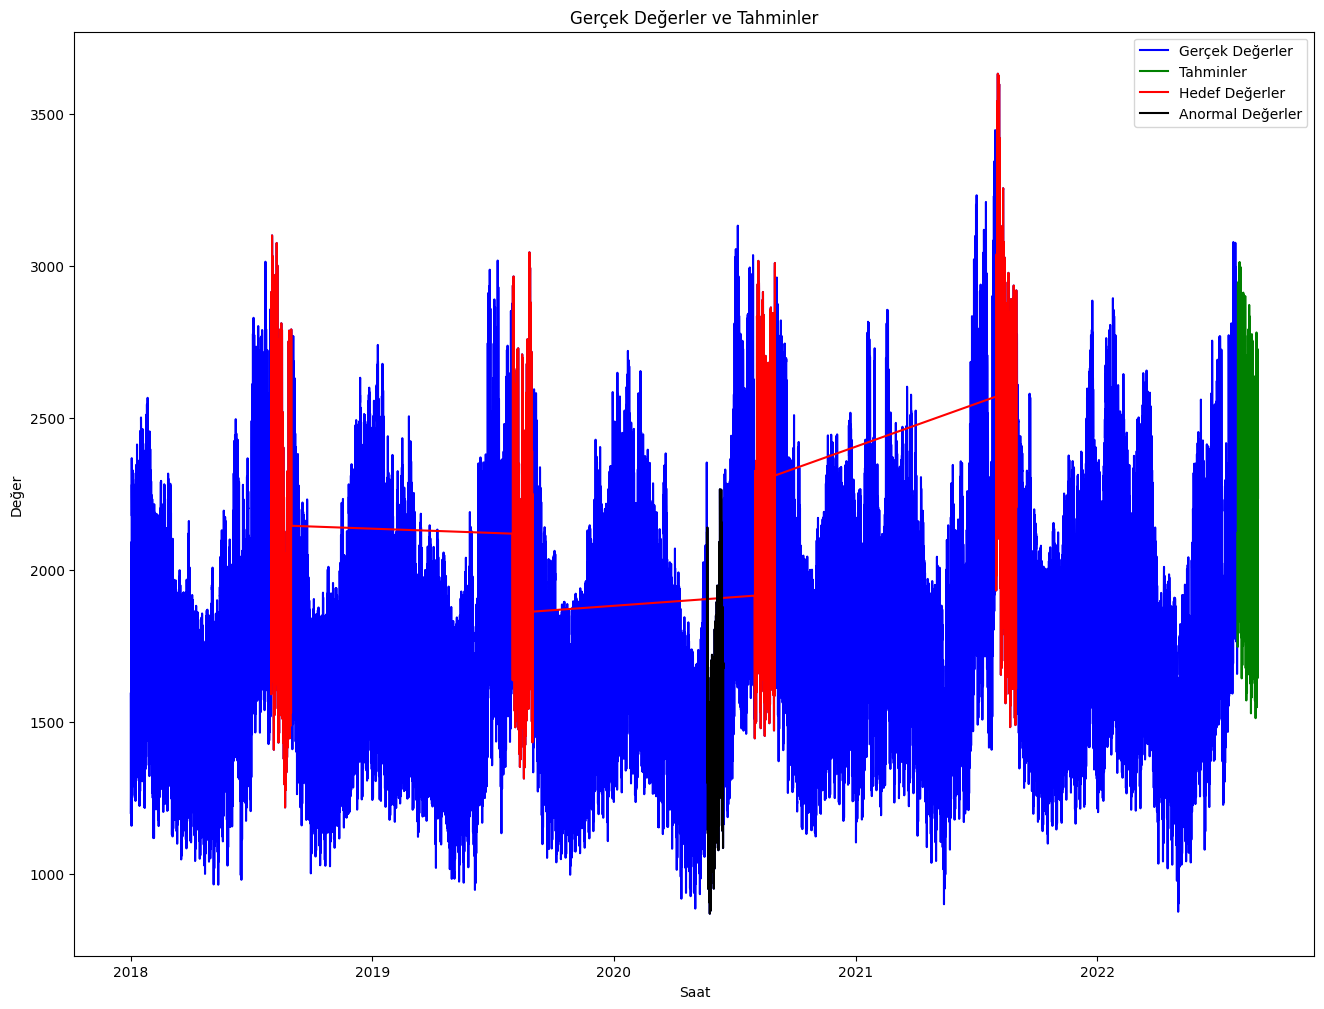

In [32]:
plt.figure(figsize=(16,12) , dpi = 100)
preds_plot(data , future_data2 , target_data , anomaly_data)

In [ ]:
# Done